# Perform decoding and encoding
Decode ROI and continuous images into text and encode text into continuous image.

NOTE: Continuous image decoding still has some problems.

In [1]:
%matplotlib inline
from os.path import join

import nibabel as nib
from nilearn import plotting
from nltools.mask import create_sphere

from gclda.model import Model
from gclda.decode import Decoder
from gclda.utils import plot_brain
from gclda.utils import get_resource_path

/Users/tsalo/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
%%time
# Load example model and initialize decoder
model = Model.load(join(get_resource_path(), 'models',
                        'Neurosynth2015Filtered2',
                        'model_200topics_2015Filtered2.pkl'))
decoder = Decoder(model)

model.display_model_summary()

--- Model Summary ---
 Current State:
	 Current Iteration   = 1000
	 Initialization Seed = 1
	 Current Log-Likely  = -11529616.3744
 Model Hyper-Parameters:
	 Symmetric = 0.1
	 n_topics  = 200
	 n_regions = 2
	 alpha     = 0.010
	 beta      = 0.010
	 gamma     = 1.000
	 delta     = 25.000
	 roi_size  = 1.000
	 dobs      = 50
 Model Training-Data Information:
	 Dataset Label                 = 20170813
	 Word-Tokens (n_word_tokens)   = 554135
	 Peak-Tokens (n_peak_tokens)   = 413292
	 Word-Types (n_word_labels)    = 6754
	 Documents (n_docs)            = 11404
	 Peak-Dimensions (n_peak_dims) = 3
CPU times: user 20.2 s, sys: 1.84 s, total: 22 s
Wall time: 23.7 s


## Decode a region of interest
### From a file

               Weight
Term                 
face         0.043115
perception   0.042964
category     0.028514
perceptual   0.026070
faces        0.023841
categories   0.021027
selectivity  0.019469
reveal       0.018077
bottom       0.016086
sites        0.013957
CPU times: user 11.4 s, sys: 13.8 s, total: 25.2 s
Wall time: 21.3 s


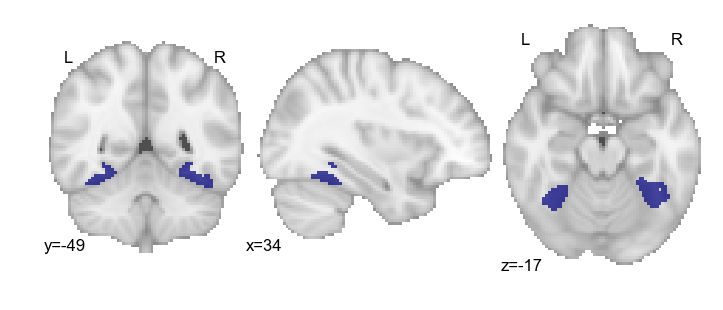

In [3]:
%%time
roi_file = 'data/fusiform.nii.gz'
fusiform_df = decoder.decode_roi(roi_file)
fusiform_df = fusiform_df.sort_values(by='Weight', ascending=False)
print(fusiform_df.head(10))

roi_img = nib.load(roi_file)
fig = plotting.plot_roi(roi_img, display_mode='ortho',
                        draw_cross=False)

### From a set of coordinates

/Users/tsalo/anaconda/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:462: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


              Weight
Term                
perceptual  0.069008
perception  0.060999
face        0.056113
affect      0.031957
faces       0.030755
identity    0.029151
perceived   0.025459
viewing     0.018721
responds    0.016562
image       0.015727
CPU times: user 14.2 s, sys: 8.04 s, total: 22.3 s
Wall time: 20 s


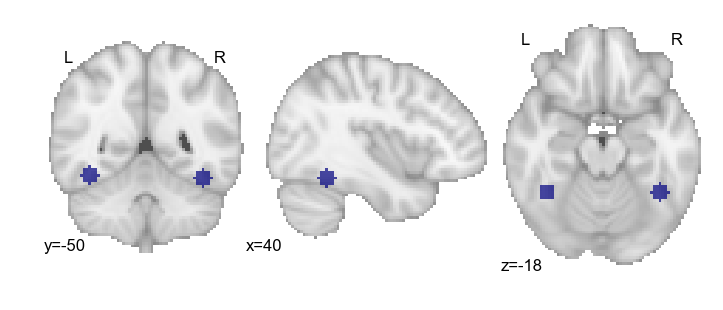

In [4]:
%%time
# Peak coordinates from Neurosynth fusiform meta-analysis.
coords = [[-40, -50, -16],
          [40, -50, -18]]
radii = [6] * len(coords)

# Create mask image
mask_data = (model.dataset.masker.volume.get_data()!=0).astype(int)
affine = model.dataset.masker.volume.affine
mask = nib.Nifti1Image(mask_data, affine)

roi_img = create_sphere(coords, radius=radii, mask=mask)
fusiform_df = decoder.decode_roi(roi_img)
fusiform_df = fusiform_df.sort_values(by='Weight', ascending=False)
print(fusiform_df.head(10))

fig = plotting.plot_roi(roi_img, display_mode='ortho',
                        draw_cross=False)

## Decode a continuous image
For some reason, the seemingly relevant features actually have the lowest weights, which is why `ascending` is currently set to `True`. We need to look into why this is happening. Also, when we decode `pFgA`, `pAgF`, `pFgA_given_pF=0.50`, or `pAgF_given_pF=0.50` images, we don't even get that pattern.

              Weight
Term                
face       -0.085248
faces      -0.063257
visual     -0.060802
emotional  -0.037757
perception -0.023140
perceptual -0.016479
pictures   -0.016396
semantic   -0.014536
encoding   -0.013991
color      -0.013832
CPU times: user 12.8 s, sys: 8.25 s, total: 21 s
Wall time: 19 s


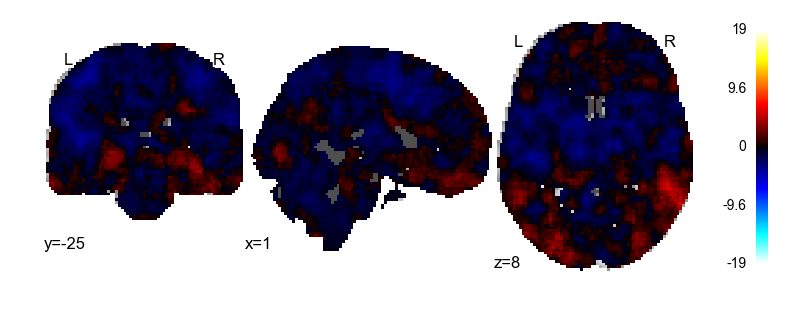

In [5]:
%%time
continuous_file = 'data/faces_specificity_z.nii.gz'
faces_df = decoder.decode_continuous(continuous_file)
faces_df = faces_df.sort_values(by='Weight', ascending=True)
print(faces_df.head(10))

continuous_img = nib.load(continuous_file)
fig = plotting.plot_stat_map(continuous_img, display_mode='ortho', 
                             threshold=.001, draw_cross=False)

## Encode text into an image

CPU times: user 12.3 s, sys: 7.64 s, total: 20 s
Wall time: 17.6 s


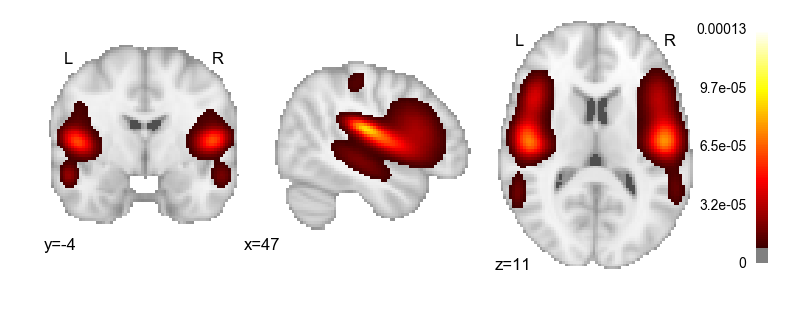

In [6]:
%%time
text = 'painful stimulation during a language task'
encoded_arr = decoder.encode(text)
affine = model.dataset.masker.volume.affine
encoded_image = nib.Nifti1Image(encoded_arr, affine)
fig = plotting.plot_stat_map(encoded_image, display_mode='ortho', 
                             threshold=.00001, draw_cross=False)